## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:

- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz _jet.bmp_ i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (_lm_).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
   Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
   W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
   Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy _H1_ i _H2_.
   Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
   Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
   Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
   Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
   Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
   $C_{1n} = (lm)*C1;$<br>
   $C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
   Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
   Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.


In [95]:
url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/02_Point/'

In [96]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

fileName = 'jet.bmp'
if not os.path.exists(fileName):
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

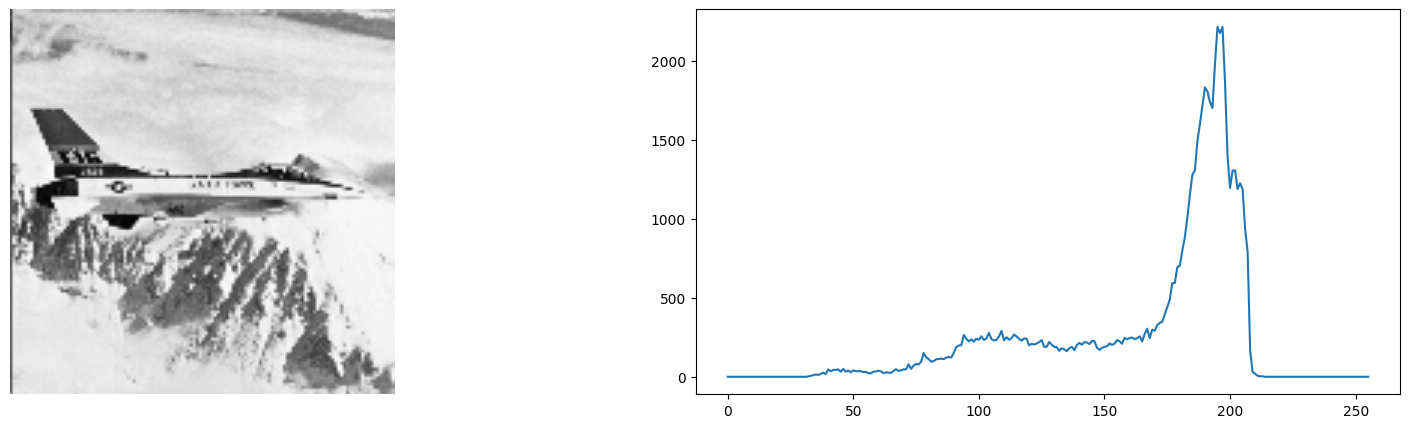

In [97]:
image = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([image], [0], None, [256], [0, 256])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
axs[0].imshow(image, 'gray')
axs[0].axis('off')
axs[1].plot(hist)

In [98]:
def bbhe_divider(img):
    return int(np.mean(img))


def dsihe_divider(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    cum_hist = hist.cumsum()
    return np.abs(cum_hist - sum(hist) / 2).argmin()

In [99]:
def split_histogram(hist, divider):
    # hist1, hist2 = hist[hist <= divider], hist[hist > divider]
    cum_hist1, cum_hist2 = np.cumsum(
        hist[:divider+1]), np.cumsum(hist[divider+1:])
    cum_hist1 = cum_hist1 / cum_hist1.max()
    cum_hist2 = cum_hist2 / cum_hist2.max()
    return cum_hist1, cum_hist2

In [100]:
def create_lut(C1, C2, divider):
    lut1 = C1 * divider
    lut2 = divider + 1 + (255-divider-1)*C2
    return np.concatenate((lut1, lut2)).astype(np.uint8)

In [101]:
def map_using_encoding_table(image, encoding_table):
    mapper = np.vectorize(lambda x: encoding_table[x])
    return mapper(image.flatten()).reshape(image.shape)

In [102]:
def map_image(image, sep_function):
    divider = sep_function(image)
    hist = cv2.calcHist([image], [0], None, [255], [0, 255])
    C1, C2 = split_histogram(hist, divider)
    lut = create_lut(C1, C2, divider)
    # return lut[image]
    return map_using_encoding_table(image, lut)

In [103]:
def plot_img_and_hist(imgs: list[np.ndarray]):
    fig, ax = plt.subplots(len(imgs), 2)
    fig.set_size_inches(15, 15)
    for i, img in enumerate(imgs):
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        ax[i, 0].imshow(img, 'gray', vmin=0, vmax=256)
        ax[i, 0].axis('off')
        ax[i, 1].plot(hist)
        ax[i, 1].grid()

In [104]:
def equalize_histogram_he(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    cum_hist = hist.cumsum()
    cum_hist = (cum_hist - cum_hist.min()) * 255 / \
        (cum_hist.max() - cum_hist.min())
    img = map_using_encoding_table(img, cum_hist)
    return img

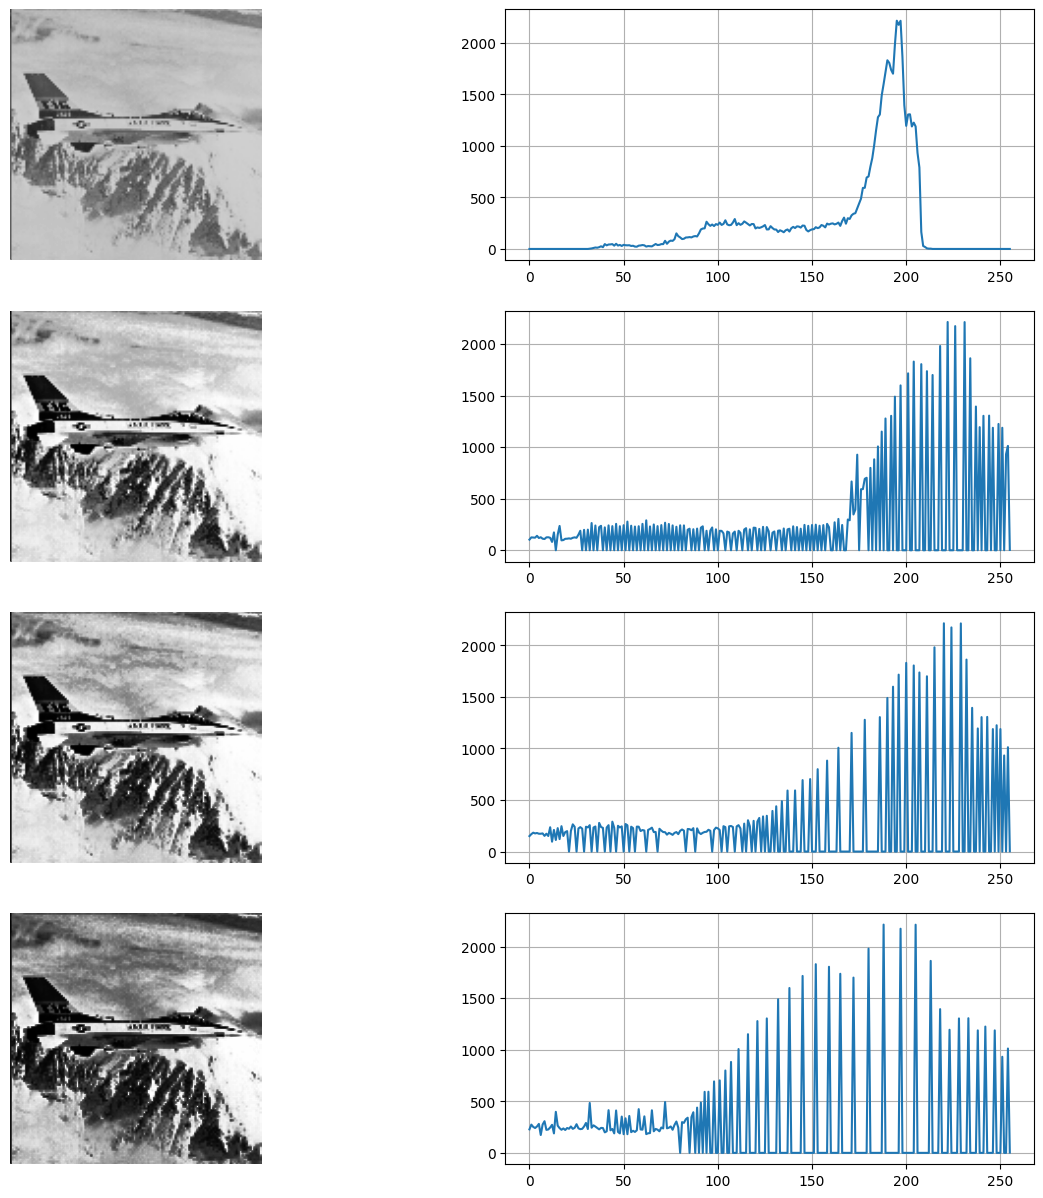

In [105]:
image_bbhe = map_image(image, bbhe_divider)
image_dsihe = map_image(image, dsihe_divider)
image_he = equalize_histogram_he(image)

plot_img_and_hist([image, image_bbhe, image_dsihe, image_he])